In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import copy

tf.enable_eager_execution()

In [4]:
def play_episode(env, player, len_episode):
    # reset
    s = env.reset()
    total_r = 0
    r = 0
    w = np.random.randint(8)
    
    # play an episode
    for _ in range(len_episode):
        a = player.choose_action(s, r)
        s, r = env.step(s, a)
        total_r += r
        
    return total_r/len_episode

In [10]:
def recursive_action_choice(heirarchy, x):
    # want to keep track of which policies are getting called
    # and how much
    a = heirarchy[0](x)
    if len(heirarchy) == 1:
        return a
    elif entropy(a) < n_actions//2:
        return a
    else:
        return recursive_action_choice(heirarchy[1:], x)

class Heirarchy():
    """
    Residual policy learning.
    Learn to act when uncertain.
    
    
    What if each policy were trained at different discounts!?
    The first one with low discount.
    The next one with higher.
    ...?
    
    Higher up in the heirarchy corresponds to more specific knowledge.
    What to do in a specific situation.
    More general knowledge. Is lower down.
    """
    def __init__(self, n_states, n_actions):
        self.n_actions = n_actions
        self.policies = [TabularSARSA(n_states, n_actions)]
        self.record = []
        self.step = 0
        
    def choose_action(self, s, r):
        # want to keep track of which policies are getting called
        # and how much
        certain = False
        counter = 0
        while not certain and (counter < len(self.policies)):
            pi = self.policies[counter]
            qs = pi(s)  # pi(s) returns the Q values
            p_a = softmax(qs)
            # p is based on the value. 
            # but this means high entropy can come from having many good options... 

            if entropy(p_a) < 0.25:
                certain = True
            
            counter += 1

        a = pi.choose_action(s, r)
            
        # track which policies are being used
        self.record.append(counter)
        
        # only train the latest policy.
        if self.step % 1000 == 0 and self.step > 0:
            self.policies.append(TabularSARSA(n_states, n_actions))
#         self.policies[-1].choose_action(s, r)
        
        self.step += 1
        
        return a

In [16]:
n_actions = 3
n_states = 512
env = Env(n_states, n_actions)
player = Heirarchy(n_states, n_actions)

In [17]:
play_episode(env, player, 50000)

0.00214

50


(array([5001., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        4999.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <a list of 10 Patch objects>)

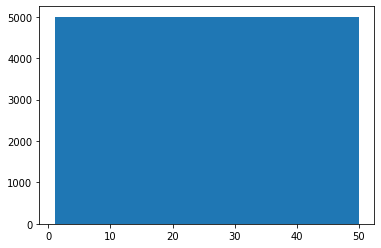

In [18]:
print(len(player.policies))
plt.hist(player.record)

In [ ]:
# damn. lower level policies are certain when they shouldnt be...
# also the value changes.

Show temporal abstraction with preirarchy.

- Learn a prior. In this case, a policy that repeats actions n times.
- Learn a new policy, which is regularised with the prior.

In [81]:
class EntropyPrior():
    def __init__(self):
        self.policy = MLP()

    def __call__(self, s_t):
        return tf.ones(shape=(self.n_actions,))/self.n_actions
    
class NStepPrior():
    def __init__(self, n_actions):
        self.n = 2
        self.n_actions = n_actions

    def __call__(self, s_t):
        # needs to know the most recent action and the time step.
        # can cheat and add these to the state vector
        # generalising n to values higher than 2 would require storing more actions
        a_tm1 = s_t[-1]
        t = s_t[-2]
        
        if t.numpy() % self.n == 0:
            return tf.ones(shape=(self.n_actions,))/self.n_actions
        else:
            return tf.one_hot(int(a_tm1), self.n_actions)
        
# want other priors can we write down that might help!?
# - repeated actions for long periods of time is probably bad?! although, not always...
# - 

In [172]:
def sample(logits):
    g = -tf.log(-tf.log(tf.random.uniform(logits.shape)))
    return tf.argmax(logits + g)

n_actions = 8
prior = NStepPrior(n_actions, 2)
a_t = np.random.randint(0, n_actions)
for i in range(10):
    s_t = tf.cast(tf.constant([0,0,i,int(a_t)]), tf.float32)
    a_t = np.random.choice(range(n_actions), p=prior(s_t))
    print(a_t)

5
5
1
1
0
0
1
1
6
6


In [68]:
def KL(P, Q):
    return -tf.reduce_sum(P * tf.log(Q/P))

class Pierarchy():
    def __init__(self, prior):
        self.prior = prior
        self.policy = MLP()
        
    def __call__(self, s_t):
        return softmax(self.policy(s_t))
        
    def loss_fn(self, s_t, a_t, r_t, R_t):
        P = self.__call__(s_t)
        Q = self.prior(s_t)
        prior_loss = KL(P, Q)
        
        pg_loss = PG(s, a, R)
        
        return prior_loss + pg_loss

In [ ]:
# what does better?
# - Pierarchy + EntropyPrior
# - Pierarchy + NStepPrior
# - Pierarchy + Pierarchy